<a href="https://colab.research.google.com/github/Nischal-Karki-1/Image-Compression-with-Bezier-Curves/blob/main/Image_Compression_using_Bezier_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [21]:
def normalize_t(t):
  return t/60

def calculate_control_points(sample_points):  #sample points e.g [[0,243],[1,212], [2, 243]] ...
  coeff_matrix = np.zeros((2,2))
  y_matrix = np.zeros(2)
  p0 = sample_points[0][1]
  p3 = sample_points[24][1]

  # coeff matrix
  for point in sample_points:
    t = normalize_t(point[0])
    y = point[1]
    f = -t**3 + 3*t**2 - 3*t + 1
    g = 3*t**3 - 6*t**2 + 3*t
    h = -3*t**3 + 3*t**2
    i = t**3
    #y = p0*f + p1*g + p2*h + p3*i

    #Efy = p0*Ef^2  + p1*Efg + p2*Efh + p3*Efi
    #Egy = p0*Efg  + p1*Eg^2 + p2*Egh + p3*Egi
    #Ehy = p0*Efh  + p1*Egh + p2*Eh^2 + p3*Ehi
    #Eiy = p0*Efi  + p1*Egi + p2*Ehi + p3*Ei^2

    coeff_matrix[0][0] += g**2
    coeff_matrix[0][1] += g*h
    y_matrix[0] += g*(y-p0*f-p3*i)

    coeff_matrix[1][0] += g*h
    coeff_matrix[1][1] += h**2
    y_matrix[1] += h*(y-p0*f-p3*i)

  result = np.linalg.solve(coeff_matrix, y_matrix)
  result = [p0] + list(result) + [p3]
  return np.asarray(result)

def calc_5x5_pixels(coeffs, size, row):
  c0, c1, c2, c3 = coeffs
  arr = []
  for i in range(size): #0, 1,2,..,24
    t= normalize_t(i)
    y = (c0 * (-t**3 + 3*t**2 - 3*t + 1) +
    c1 * ( 3*t**3 - 6*t**2 + 3*t) +
    c2 * ( -3*t**3 + 3*t**2) +
    c3 * t**3)
    arr.append(round(y))
  arr = np.asarray(arr)
  arr.resize((row,row))
  return arr

def add_t(arr, size):
  x = np.reshape(arr, size)
  return [[i,x[i]] for i in range(size)]


In [22]:
def encode(img):
  SIZE = 600
  # channels
  red = img[:,:,0]   #600x600
  green = img[:,:,1]
  blue = img[:,:,2]

  red_final = []
  blue_final = []
  green_final = []
  STACK = []

  for r in range(0, SIZE, 5):  #row
    red_temp = []
    blue_temp = []
    green_temp =[]
    row_stack = []

    for c in range(0, SIZE, 5):  #column
      r_25 = red[r:r+5, c:c+5]  #5x5
      g_25 = green[r:r+5, c:c+5]
      b_25 = blue[r:r+5, c:c+5]

      rr = add_t(r_25, 25)   #e.g [0,r-value]
      g = add_t(g_25, 25)
      b = add_t(b_25, 25)

      r_coeffs = calculate_control_points(rr)
      g_coeffs = calculate_control_points(g)
      b_coeffs = calculate_control_points(b)

      row_stack.append(np.stack((r_coeffs, g_coeffs, b_coeffs)))

    STACK.append(row_stack)

  return STACK



In [23]:
def decode(STACK):
  SIZE = 25
  ROW = 5
  red_final_list = []
  blue_final_list = []
  green_final_list = []

  for row in STACK:
    red_temp = []
    blue_temp = []
    green_temp =[]

    for col in row:
      red_temp.append(calc_5x5_pixels(col[0], SIZE, ROW))
      green_temp.append(calc_5x5_pixels(col[1], SIZE, ROW))
      blue_temp.append(calc_5x5_pixels(col[2], SIZE, ROW))

    red_final_list.append(np.concatenate(red_temp, axis=1))
    green_final_list.append(np.concatenate(green_temp, axis=1))
    blue_final_list.append(np.concatenate(blue_temp, axis=1))

  red_final = np.concatenate(red_final_list, axis=0)   #whole image red pixel values
  green_final = np.concatenate(green_final_list, axis=0)
  blue_final = np.concatenate(blue_final_list, axis=0)

  return np.stack((red_final, green_final, blue_final), axis=2)



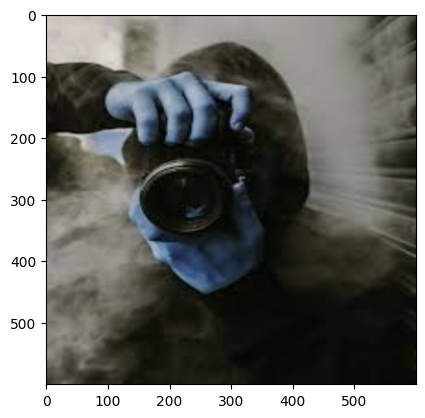

In [30]:
img = cv2.imread('cameraman.jpg')
img = cv2.resize(img, (600,600))
plt.imshow(img)



plt.show()

In [31]:
encoded_data = encode(img)


In [26]:
#stored
encoded_data

[[array([[40.        , 25.29086382, 43.94678417, 33.        ],
         [49.        , 34.29086382, 52.94678417, 42.        ],
         [39.        , 24.29086382, 42.94678417, 32.        ]]),
  array([[33.        , 36.34562126, 26.32271949, 33.        ],
         [42.        , 45.34562126, 35.32271949, 42.        ],
         [32.        , 35.34562126, 25.32271949, 32.        ]]),
  array([[34.        , 37.549008  , 22.95952331, 32.        ],
         [43.        , 46.549008  , 31.95952331, 41.        ],
         [33.        , 36.549008  , 21.95952331, 31.        ]]),
  array([[36.        , 31.24162443, 30.90030506, 32.        ],
         [45.        , 40.24162443, 39.90030506, 41.        ],
         [35.        , 30.24162443, 29.90030506, 31.        ]]),
  array([[34.        , 30.78298882, 30.83865639, 32.        ],
         [43.        , 39.78298882, 39.83865639, 41.        ],
         [33.        , 29.78298882, 29.83865639, 31.        ]]),
  array([[32.        , 32.60614596, 31.781986

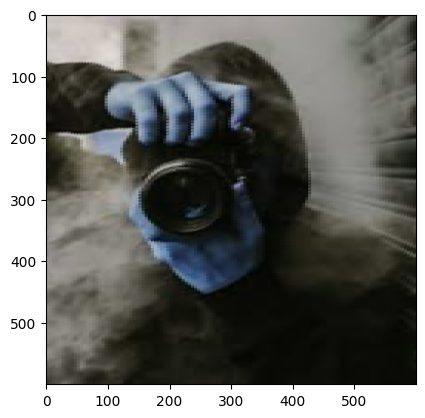

In [32]:
output = decode(encoded_data)
plt.imshow(output)
plt.show()

In [34]:
cv2.imwrite('output.jpg',output)

True